In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time

In [2]:
def load_data(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f'Dataframe shape: {df.shape}')
        print(f'Dataframe columns: {df.columns.tolist()}')
        df.info()
        return df

    except Exception as e:
        print(f'Error Loading data: {e}')
    return None


def distribution_plot(df, features):
    start_time = time.time()
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[feature], kde=True, stat="density", linewidth=0)

        # Calculate mean and standard deviation
        mean_value = df[feature].mean()
        std_deviation = df[feature].std()

        # Plot vertical lines for mean and std deviation
        plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
        plt.axvline(mean_value + std_deviation, color='g', linestyle=':', label=f'Std Dev: {std_deviation:.2f}')
        plt.axvline(mean_value - std_deviation, color='g', linestyle=':')

        plt.title(f'Distribution of {feature}')
        plt.legend()
        plt.show()
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'elapsed time : {elapsed_time}')
    return plt


In [3]:
filepath = "../attack-sample-3m.csv"
df = load_data(filepath)

print(df.head(10))

/tmp/ipykernel_180288/1058036564.py:3: DtypeWarning: Columns (0,1,3,10,11,13,14,15,18,19,20,21,22,24,25,26,27,28,30,31,32,33,34,35,36,37,42,44,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Dataframe shape: (3000000, 74)
Dataframe columns: ['frame.number', 'frame.len', 'frame.time', 'frame.time_epoch', 'frame.protocols', 'eth.src', 'eth.dst', 'eth.type', 'ip.src', 'ip.dst', 'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset', 'ip.proto', 'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport', 'tcp.dstport', 'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.window_size', 'tcp.checksum', 'tcp.stream', 'udp.srcport', 'udp.dstport', 'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code', 'icmp.checksum', 'http.request.method', 'http.request.uri', 'http.request.version', 'http.request.full_uri', 'http.response.code', 'http.user_agent', 'http.content_length_header', 'http.content_type', 'http.cookie', 'http.host', 'http.referer', 'http.location', 'http.authorization', 'http.connection', 'dns.qry.name', 'dns.qry.type', 'dns.qry.class', 'dns.flags.response', 'dns.flags.recdesired', 'dns.flags.rcode', 'dns.resp.

In [4]:
# Checking for missing values
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() * 100 / len(df)

# Categorize columns based on missing value percentages
missing_categories = {
    "0-20%": missing_percentage[(missing_percentage > 0) & (missing_percentage <= 20)].index.tolist(),
    "20-40%": missing_percentage[(missing_percentage > 20) & (missing_percentage <= 40)].index.tolist(),
    "40-60%": missing_percentage[(missing_percentage > 40) & (missing_percentage <= 60)].index.tolist(),
    "60-80%": missing_percentage[(missing_percentage > 60) & (missing_percentage <= 80)].index.tolist(),
    "80-100%": missing_percentage[(missing_percentage > 80) & (missing_percentage <= 100)].index.tolist()
}

# Print out the categorized lists
for category, features in missing_categories.items():
    print(f"{category} Missing Values: {features}")


0-20% Missing Values: ['ip.src', 'ip.dst', 'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset', 'ip.proto', 'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport', 'tcp.dstport', 'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.window_size', 'tcp.checksum', 'tcp.stream']
20-40% Missing Values: []
40-60% Missing Values: []
60-80% Missing Values: ['http.request.method', 'http.request.uri', 'http.request.version', 'http.request.full_uri', 'http.response.code', 'http.user_agent', 'http.content_length_header', 'http.content_type', 'http.host', 'http.connection']
80-100% Missing Values: ['udp.srcport', 'udp.dstport', 'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code', 'icmp.checksum', 'http.cookie', 'http.referer', 'http.location', 'http.authorization', 'dns.qry.name', 'dns.qry.type', 'dns.qry.class', 'dns.flags.response', 'dns.flags.recdesired', 'dns.flags.rcode', 'dns.resp.ttl', 'dns.resp.len', 'smtp.req.command', '

The sample has more TCP packets than the UDP:

- 0-20% Missing Values --> these are the common features for each packet (Layer 3 and 4 of the OSI Network layer). In other words, each packet has all/the majority of these features regardless of the application protocol (HTTP, DNS,POP3, SMTP,..)

- 60-80% Missing Values --> These are http related, meaning lots of packets are not related to the http protocol

- 80-100% Missing Values --> these are udp, DNS, pop, imap,smtp related and one packet cannot have values for all of these.

If a packet is a TCP packet, it won't have UDP-specific features and vice versa. Hence, the missing values in these cases aren't really 'missing' in the traditional sense; they're simply not applicable.

This information will help me with my feature selection.

In [5]:
# I would like to now gain more insight about the tcp and udp proportion in the df
# Check for rows where both udp.srcport and tcp.srcport are non-null
both_set = df[(df['udp.srcport'].notnull()) & (df['tcp.srcport'].notnull())]
print(f"Number of rows with both UDP and TCP source ports set: {len(both_set)}")
both_set

Number of rows with both UDP and TCP source ports set: 1


,frame.number,frame.len,frame.time,frame.time_epoch,frame.protocols,eth.src,eth.dst,eth.type,ip.src,ip.dst,...,imap.request.command,imap.response,ftp.request.command,ftp.request.arg,ftp.response.code,ftp.response.arg,ipv6.src,ipv6.dst,ipv6.plen,alert
2042160,frame.number,frame.len,frame.time,frame.time_epoch,frame.protocols,eth.src,eth.dst,eth.type,ip.src,ip.dst,...,imap.request.command,imap.response,ftp.request.command,ftp.request.arg,ftp.response.code,ftp.response.arg,ipv6.src,ipv6.dst,ipv6.plen,alert


In [6]:
# This row should be removed. It's the duplicate of the column names.
df = df[df['frame.number'] != 'frame.number']

There is a feature called "frame.protocols" which has the list of all protocols used in the packet. I'd like to see the variety of protocols in the dataset. I first need to break down these lists into individual protocols and then count their occurrences.

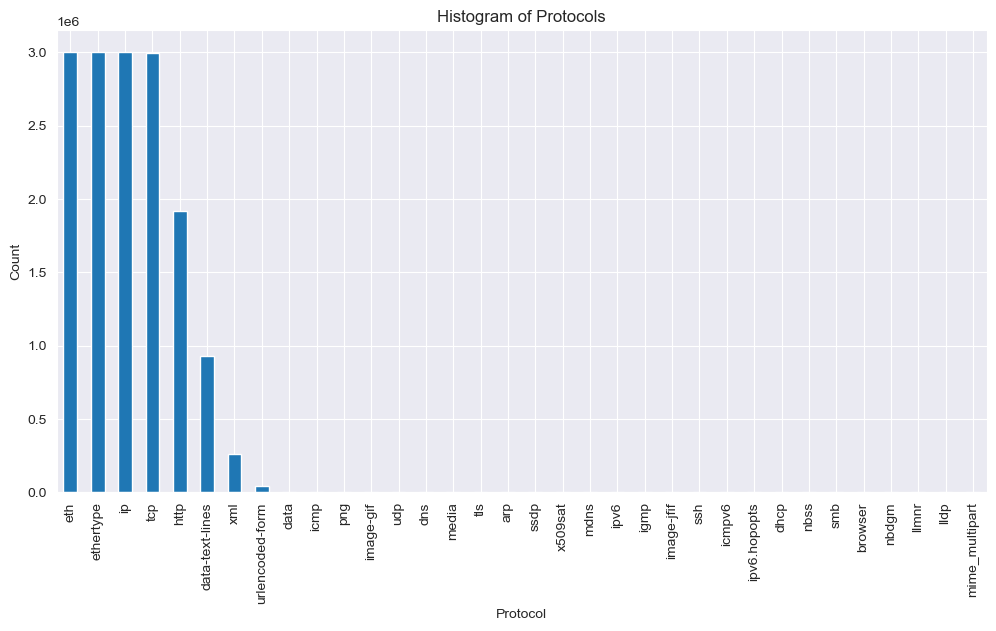

In [7]:
# Split the 'frame.protocols' entries into individual protocols and stack them
protocols = df['frame.protocols'].str.split(':', expand=True).stack()

# Count the occurrences of each protocol
protocol_counts = protocols.value_counts()

# Plotting
plt.figure(figsize=(12, 6))
protocol_counts.plot(kind='bar')
# Format y-axis to show actual numbers
plt.title('Histogram of Protocols')
plt.xlabel('Protocol')
plt.ylabel('Count')
# plt.xticks(rotation=45)
plt.show()

In [8]:
# Print the top 10 protocols with their counts
print(protocol_counts.head(10))

eth                2999999
ethertype          2999999
ip                 2999821
tcp                2996268
http               1915842
data-text-lines     930433
xml                 260543
urlencoded-form      40628
data                  2496
icmp                  2336
Name: count, dtype: int64


At this stage I would like to simplify the problem as much as I can. Due to my domain knowledge and considering the insight I have got from the dataset, I will be including tcp-related features listed below in addition to some frame-related columns. As long as my model gives me 50% of accuracy, I'm glad. I can always come back and add more features. I will be keeping the feature "alert" as I can use this in order to evaluate how my model is doing.

In [10]:
columns_to_keep = ['frame.number', 'frame.time', 'frame.protocols', 'tcp.seq', 'tcp.stream', 'tcp.srcport','tcp.dstport','tcp.len', 'tcp.window_size', 'tcp.flags.syn', 'tcp.flags.reset','udp.srcport', 'udp.dstport', 'ip.src', 'ip.dst', 'alert']


In [11]:
df = df[columns_to_keep]

joblib.dump(df,'../chosen_features_df.csv')

['../chosen_features_df.csv']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999999 entries, 0 to 2999999
Data columns (total 16 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   frame.number     object
 1   frame.time       object
 2   frame.protocols  object
 3   tcp.seq          object
 4   tcp.stream       object
 5   tcp.srcport      object
 6   tcp.dstport      object
 7   tcp.len          object
 8   tcp.window_size  object
 9   tcp.flags.syn    object
 10  tcp.flags.reset  object
 11  udp.srcport      object
 12  udp.dstport      object
 13  ip.src           object
 14  ip.dst           object
 15  alert            object
dtypes: object(16)
memory usage: 453.6+ MB


In [3]:
df = joblib.load('../chosen_features_df.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999999 entries, 0 to 2999999
Data columns (total 16 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   frame.number     object
 1   frame.time       object
 2   frame.protocols  object
 3   tcp.seq          object
 4   tcp.stream       object
 5   tcp.srcport      object
 6   tcp.dstport      object
 7   tcp.len          object
 8   tcp.window_size  object
 9   tcp.flags.syn    object
 10  tcp.flags.reset  object
 11  udp.srcport      object
 12  udp.dstport      object
 13  ip.src           object
 14  ip.dst           object
 15  alert            object
dtypes: object(16)
memory usage: 389.1+ MB


In [5]:
df.isna().sum()

frame.number             0
frame.time               0
frame.protocols          0
tcp.seq               3731
tcp.stream            3731
tcp.srcport           3731
tcp.dstport           3731
tcp.len               3731
tcp.window_size       3731
tcp.flags.syn         3731
tcp.flags.reset       3731
udp.srcport        2998760
udp.dstport        2998760
ip.src                 179
ip.dst                 179
alert                    0
dtype: int64

I will drop the rows with null values for tcp.len

In [4]:
df = df.dropna(subset=['tcp.len'])

In [7]:
df.isna().sum()

frame.number             0
frame.time               0
frame.protocols          0
tcp.seq                  0
tcp.stream               0
tcp.srcport              0
tcp.dstport              0
tcp.len                  0
tcp.window_size          0
tcp.flags.syn            0
tcp.flags.reset          0
udp.srcport        2996268
udp.dstport        2996268
ip.src                   0
ip.dst                   0
alert                    0
dtype: int64

In [5]:
df_sample_1500 = df.sample(n= 1500, random_state=42)
df_sample_1500.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 475736 to 172870
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   frame.number     1500 non-null   object
 1   frame.time       1500 non-null   object
 2   frame.protocols  1500 non-null   object
 3   tcp.seq          1500 non-null   object
 4   tcp.stream       1500 non-null   object
 5   tcp.srcport      1500 non-null   object
 6   tcp.dstport      1500 non-null   object
 7   tcp.len          1500 non-null   object
 8   tcp.window_size  1500 non-null   object
 9   tcp.flags.syn    1500 non-null   object
 10  tcp.flags.reset  1500 non-null   object
 11  udp.srcport      0 non-null      object
 12  udp.dstport      0 non-null      object
 13  ip.src           1500 non-null   object
 14  ip.dst           1500 non-null   object
 15  alert            1500 non-null   object
dtypes: object(16)
memory usage: 199.2+ KB


In [6]:
features = ['tcp.seq', 'tcp.stream', 'tcp.srcport', 'tcp.dstport',
 'tcp.len', 'tcp.window_size', 'tcp.flags.syn', 'tcp.flags.reset', 'alert']

In [ ]:
distribution_plot(df_sample_1500, features)

In [8]:
#  I would like to scale the features then plot them again
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns = features)

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, stat="density", linewidth=0)

    # Calculate mean and standard deviation
    mean_value = df[feature].mean()
    std_deviation = df[feature].std()

    # Plot vertical lines for mean and std deviation
    plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(mean_value + std_deviation, color='g', linestyle=':', label=f'Std Dev: {std_deviation:.2f}')
    plt.axvline(mean_value - std_deviation, color='g', linestyle=':')

    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

#  I cannot see a clean Gaussian distribution in any of the features.

#  I would like to see the pairplot of the feature to see if anything stands out.
sns.pairplot(df)
plt.show()


# Boxplot for outlier detection
df.plot(kind='box', subplots=True, layout=(2,3), figsize=(15, 10))
plt.show()

#  Let's proceed with the corelation analysis of the features
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='cividis')
plt.title('Correlation Matrix')
plt.show()

# After considering the distribution of the chosen features, none of them look like a
# Gaussian distribution.

# I will be focusing on only one feature now: tcp.len.  it seems that the distribution
# of tcp.len is multimodal with several peaks, and it's not symmetrical or bell-shaped
# like a Gaussian distribution.

# There are a few key observations we can make from the plot:
# 1. Presence of Modes: There are several distinct peaks, which could indicate the
# presence of specific groups or types of traffic within my TCP data.

# 2. Mean and Standard Deviation: The mean and standard deviation are marked on the plot.
# The mean is not centered amongst the modes, which is characteristic of skewed or
# multimodal distributions.

# 3. Outliers or Sparse Data: There are bars on the far right of the plot, suggesting
# the presence of outliers or a sparse distribution in the higher range of tcp.len.

# Transformations Needed: Since the data is not normally distributed, transformations
# could be applied to try to make the distribution more Gaussian-like. Given the
# multimodality, a single transformation might not be sufficient to achieve normality.

# There are 4 peaks in the distribution of this feature. I will try to see which
# protocols are there in the packets. I am doing this in batches for each peak.
#  Will need to load the original df
filepath = "data/attack-sample.csv"
df_original = load_data(filepath)
peak_traffic_1 = df_original.loc[(df_original['tcp.len'] >100) & (df_original['tcp.len'] < 250), 'frame.protocols'].str.split(':', expand=True).stack().value_counts()
print(f'** First Peak Packet Protocols: \n{peak_traffic_1}' )

peak_traffic_2 = df_original.loc[(df_original['tcp.len'] >250) & (df_original['tcp.len'] < 400), 'frame.protocols'].str.split(':', expand=True).stack().value_counts()
print(f'** Second Peak Packet Protocols: \n{peak_traffic_2}' )

peak_traffic_3 = df_original.loc[(df_original['tcp.len'] >570) & (df_original['tcp.len'] < 700), 'frame.protocols'].str.split(':', expand=True).stack().value_counts()
print(f'** Third Peak Packet Protocols: \n{peak_traffic_3}' )

peak_traffic_4 = df_original.loc[(df_original['tcp.len'] >1100) & (df_original['tcp.len'] < 1300), 'frame.protocols'].str.split(':', expand=True).stack().value_counts()
print(f'** Fourth Peak Packet Protocols: \n{peak_traffic_4}' )


#   Next step is to do Transformations on this feature to try to make the distribution
#   more Gaussian-like
feature = 'tcp.len'
distribution_plot(feature)


# I'll try to see what happens if I scale the df (z_score):
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(df[feature].values.reshape(-1,1))
# scaled_feature = scaler.fit_transform(df[[feature]].values.reshape(-1,1))
df[f'{feature}_scaled'] = scaled_feature.flatten()
distribution_plot(f'{feature}_scaled')

# I'll try to see what happens if I use the log of the df feature :
feature_log = np.log(df[[feature]] + 1 - df[[feature]].min())
df[f'{feature}_log'] = feature_log
distribution_plot(f'{feature}_log')

# I'll try to see what happens if I use the square root of the df feature :
df_sqrt = np.sqrt(df[[feature]] - df[[feature]].min() + 1)
df[f'{feature}_sqrt'] = df_sqrt
distribution_plot(f'{feature}_sqrt')

# I'll try to see what happens if I use the yeo johnson method on the feature :
yeo_johnson_transformed = power_transform(df[[feature]], method='yeo-johnson')
df[f'{feature}_yeo_johnson'] = yeo_johnson_transformed
distribution_plot(f'{feature}_yeo_johnson')

# The Box-Cox transformation is a family of power transformations that aim to stabilize
# variance and make a dataset more closely approximate a normal distribution. The Box-Cox
# transformation is a statistical technique used to transform non-normal dependent variables
# into a normal shape. Normal data is often required for various data analysis techniques
# and machine learning algorithms.

# Dealing with Skewness: If the data you're working with is not normally distributed
# (it could be skewed to the left or right), the Box-Cox transformation tries to correct
# this skewness. It does this by applying a mathematical operation to the data.
# Power Transformation: The transformation is a "power" transformation. This means it
# raises the data to a power, like squaring or taking the square root. However, the Box-Cox transformation doesn't just square or square root the data; it tries many different powers (including fractional powers) to find the best one that makes the data look most like a normal distribution.

# The Lambda (λ): The power that the Box-Cox transformation raises the data to is called
# lambda (λ). The transformation tests out many different lambda values and selects the
# one that makes the data most normal. If λ is zero, the transformation is equivalent to
# taking the natural logarithm of the data.

# Positive Values Only: The Box-Cox transformation can only be applied to positive data.
# If the data contains zeros or negative values, they must be adjusted to be positive
# before the transformation can be applied.

# Result: After the best lambda is found and applied, the skewed data should now be more
# symmetric, resembling the bell curve of a normal distribution. This can be particularly
# helpful when you need to meet the assumptions of a statistical model or algorithm that
# requires normally distributed data.
df['tcp.len'].value_counts()
# There are 219006 values of 0

min_val = df[feature].min()
if min_val <= 0:
    shift_val = abs(min_val) + 1
    df[feature] += shift_val

from scipy import stats
df[f'{feature}_box_cox'] , fitted_lambda = stats.boxcox(df[feature])
distribution_plot(df[f'{feature}_box_cox'])
# BracketError: The algorithm terminated without finding a valid bracket. Consider trying
# different initial points.
"""
I got the error: BracketError: The algorithm terminated without finding a valid bracket.
Consider trying different initial points.

This can occur when:

The range of values in the data is very narrow (e.g., many values are very close to each
other).
There is an outlier that is far away from the rest of the data, which can greatly influence
 the calculation of λ.
The data is not suitable for Box-Cox transformation due to its distribution characteristics.

"""

# I will need to treat this in chunks with 4 peaks. then I have somewhat gaussian
# distribution



# *** Now I will start training my models : z_score,isolation forest, and autoencoder. ***

0-20% Missing Values: ['ip.src', 'ip.dst', 'ip.len', 'ip.ttl', 'ip.flags', 'ip.frag_offset', 'ip.proto', 'ip.version', 'ip.dsfield', 'ip.checksum', 'tcp.srcport', 'tcp.dstport', 'tcp.len', 'tcp.seq', 'tcp.ack', 'tcp.flags', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset', 'tcp.window_size', 'tcp.checksum', 'tcp.stream']
20-40% Missing Values: []
40-60% Missing Values: []
60-80% Missing Values: ['http.request.method', 'http.request.uri', 'http.request.version', 'http.request.full_uri', 'http.response.code', 'http.user_agent', 'http.content_length_header', 'http.content_type', 'http.host', 'http.connection']
80-100% Missing Values: ['udp.srcport', 'udp.dstport', 'udp.length', 'udp.checksum', 'icmp.type', 'icmp.code', 'icmp.checksum', 'http.cookie', 'http.referer', 'http.location', 'http.authorization', 'dns.qry.name', 'dns.qry.type', 'dns.qry.class', 'dns.flags.response', 'dns.flags.recdesired', 'dns.flags.rcode', 'dns.resp.ttl', 'dns.resp.len', 'smtp.req.command', '